## Dependencies and data import

In [38]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('./dataset/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Preparation

#### Problem

This dataset is not balanced. Using the original dataset will cause some Overfitting and Wrong Correlation issues - We want our model to be certain when a fraud occurs but with it being unbalanced it would assume that in most cases there are no frauds. This means that we need to do some pre processing in order to be able to make conclusions.

No Frauds: 99.83 % 
Frauds: 0.17 % 


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

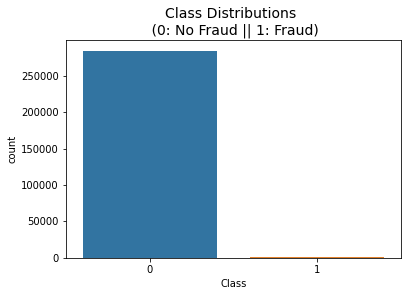

In [2]:
print('No Frauds:', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% ')
print('Frauds:', round(df['Class'].value_counts()[1]/len(df) * 100,2),'% ')

sns.countplot(x='Class', data=df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

An inbalanced dataset would raise a lot of overfitting problems, since our algorithm would assume that most transactions are not frauds. By normalizing the data (having a good proportion between frauds and not frauds), we can develop a model to find the patterns that form an actual fraud.

## Scaling and Distribution

We need to create a sub sample of the dataset that offers an equal amount of Fraud and Non-Fraud cases. This will help our algorithm to better understand patterns that determines whether a transaction is a fraud or not. We will create a subsample with a 50/50 ratio of fraud and non-fraud transactions.

There are 492 cases of fraud in our dataset. We will need to choose 492 non-fraud cases which can be done randomly from the over thousands of cases present in the data given to create this new subsample with a balanced 50/50 ratio.

### Splitting the Data on the Original Dataset

Before proceeding with the Random Undersampling technique we need to separate the original dataset for testing purposes because we want to test our models on the original testing set and not on the generated set from either of these techniques. We want to fit the model either with the undersample and oversample for our models to detect the patterns and then test it on the original testing set

In [3]:
X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


### Random Under-Sampling
In this phase we will remove data to better balance the dataset and avoid overfitting by our model. For this we have to determine how imbalanced is our class and how many instances are considered fraud transactions. We want to have an equal number of fraud and non-fraud transactions in our dataset so for that to happen we can use the 492 fraud causes and randomnly choose another 492 non-fraud transactions to create a new balanced dataset. Lastly, we will shuffle the data to check if our models can maintain a certain accuracy everytime we run this script. Bringing 284,315 non-fraud causes to only 492 makes us lose a lot of data so there is a risk that our classification models will not perform as accurate as we would like to.

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


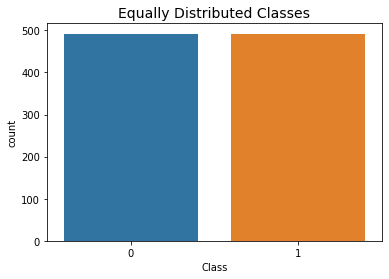

In [4]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))



sns.countplot(x='Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## Correlation Matrices
Correlation matrices are essential to understand our data. We want to learn if there are features that will heavily influence the decision if a transaction is or is not a fraud. For that, we need to use the subsample we generated above to understand which features have a high positive or negative correlation to fraud transactions.

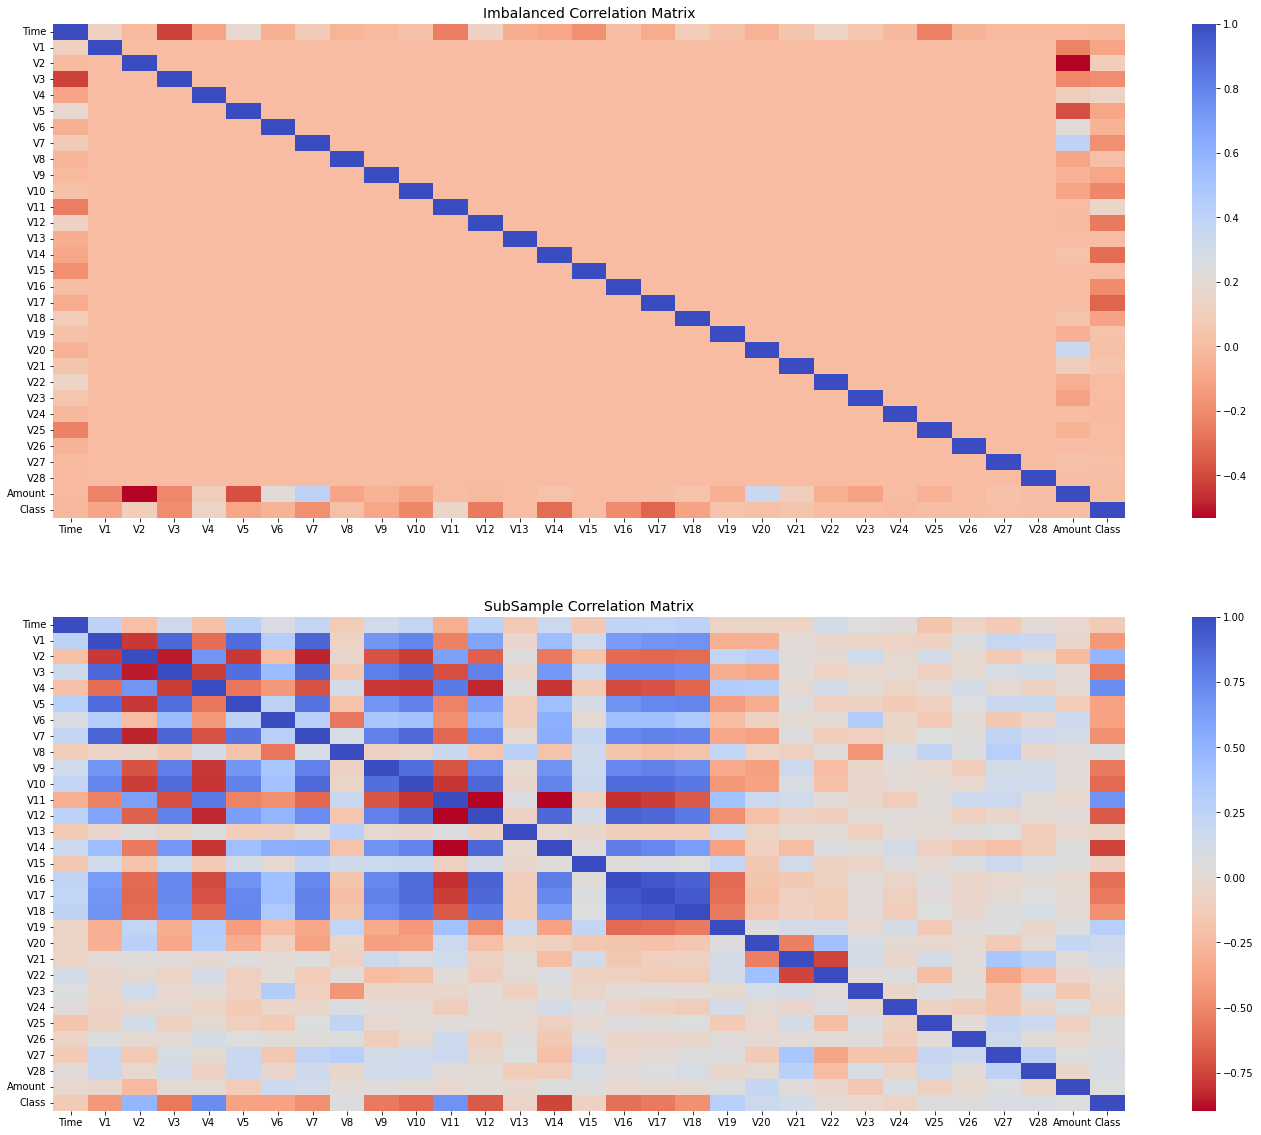

In [5]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix', fontsize=14)
plt.show()

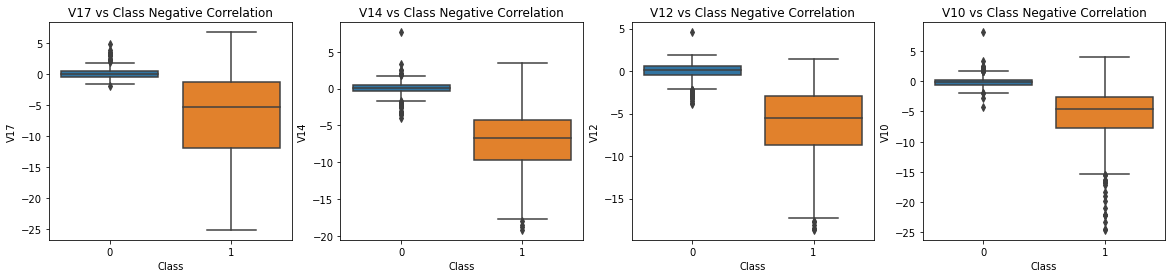

In [6]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

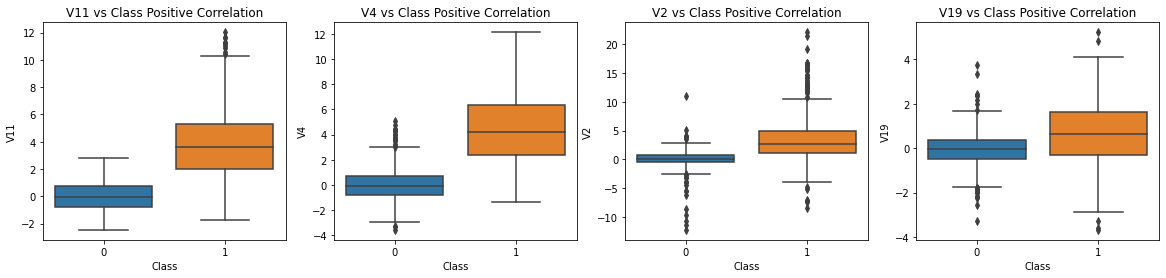

In [7]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

### Anomaly Detection
There can be some extreme outliers that have to be removed from features. This will positively impact the accuracy of our models.

We will use the Interquartile Range Method: We calculate this with the difference between the 75th percentile and 25th percentile. Then we create a threshold beyond the 75th & 25th percentile that will remove outliers that pass this threshold.

Since we want to focus on extreme outlier we have to be careful to how far do we want the threshold for removing these outliers.

/home/vregal/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vregal/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vregal/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

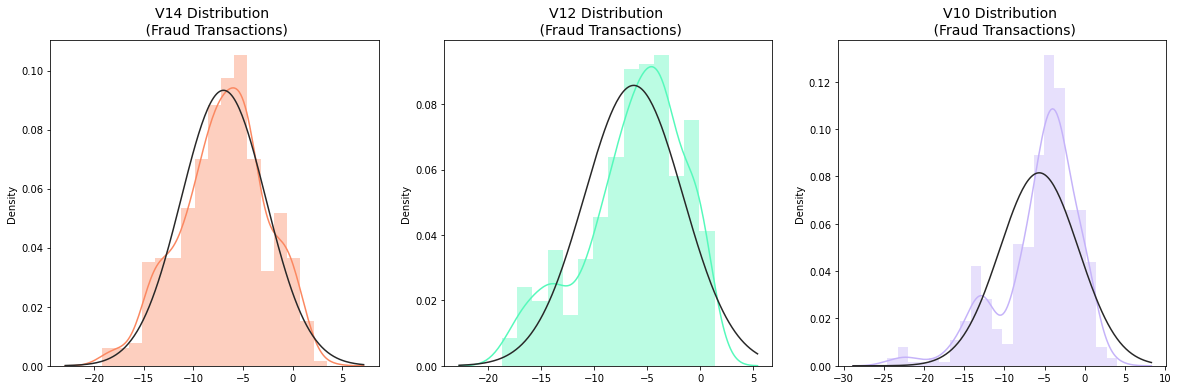

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [9]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('\n')

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('\n')


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-19.2143254902614, -18.4937733551053, -18.8220867423816, -18.0499976898594]


V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.6837146333443, -18.5536970096458, -18.0475965708216, -18.4311310279993]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 975


V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
V10 outliers: [-24.4031849699728, -23.2282548357516, -15.2399619587112, -15.1237521803455, -15.1241628144947, -22.1870885620007, -15.2318333653018, -16.7460441053944, -22.1870885620007, -15.3460988468775, -20.9491915543611, -15.2399619587112, -14.9246547735487, -16.6011969664137, -24.5882624372475, -18.9132433348732, -22.1870885620007, -15.5637913387301, -15.5637913387301, -16.2556117491401,

# Dataset analysis

In [10]:
df = new_df

print("-----CREDIT CARD FRAUD DETECTION NORMALIZED DATASET-----\n")
print(f"-> Number of instances: {len(df)}\n")

features = df.columns[:-1]
target = df.columns[-1]

print(f"-> Number of Features: {len(features)}")

for label in features:
    print(f"\t - {label}")

print("\n\tDue to privacy reasons, features have no description.\n")
print(f"-> Target label (Fraud or Non Fraud): {target}")

-----CREDIT CARD FRAUD DETECTION NORMALIZED DATASET-----

-> Number of instances: 947

-> Number of Features: 30
	 - Time
	 - V1
	 - V2
	 - V3
	 - V4
	 - V5
	 - V6
	 - V7
	 - V8
	 - V9
	 - V10
	 - V11
	 - V12
	 - V13
	 - V14
	 - V15
	 - V16
	 - V17
	 - V18
	 - V19
	 - V20
	 - V21
	 - V22
	 - V23
	 - V24
	 - V25
	 - V26
	 - V27
	 - V28
	 - Amount

	Due to privacy reasons, features have no description.

-> Target label (Fraud or Non Fraud): Class


In [11]:
print(df.shape)

(947, 31)


In [12]:
print(df.info)

<bound method DataFrame.info of             Time         V1         V2         V3        V4         V5  \
199674  133078.0  -1.560163   1.513575  -0.916212 -0.417082   0.499099   
149522   91407.0  -3.951209   2.881805  -6.421490  2.434181  -1.327325   
179071  123910.0  -0.395674   0.642944   0.399583 -0.928114   0.040403   
154286  101051.0  -1.465316  -1.093377  -0.059768  1.064785  11.095089   
30496    35953.0  -4.844372   5.649439  -6.730396  5.252842  -4.409566   
...          ...        ...        ...        ...       ...        ...   
238222  149582.0  -4.280584   1.421100  -3.908229  2.942946  -0.076205   
10484    17187.0   1.088375   0.898474   0.394684  3.170258   0.175739   
133482   80407.0  -0.712654   0.474931   1.161460 -0.827995   1.184030   
15566    26961.0 -23.237920  13.487386 -25.188773  6.261733 -17.345188   
142557   84789.0  -1.430864  -0.802529   1.123320  0.389760  -0.281214   

              V6         V7         V8        V9  ...       V21       V22  \
19

In [13]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,...,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000
mean,87617.304118,-1.938452,1.465545,-2.912859,2.049854,-1.207461,-0.687965,-2.129322,0.435844,-1.092566,...,0.490979,-0.075321,-0.034255,-0.073610,0.024146,0.038357,0.171060,0.056199,110.953041,0.482577
std,48714.294406,4.756618,3.225202,5.424397,2.966894,3.710589,1.687491,4.493477,4.287328,1.965064,...,2.442518,1.060693,1.141924,0.570755,0.644811,0.473353,0.716378,0.415762,271.126304,0.499960
min,23.000000,-30.552380,-12.231954,-31.103685,-3.565152,-22.105532,-8.423297,-21.922811,-37.353443,-9.283925,...,-6.389132,-8.887017,-19.254328,-2.028780,-4.781606,-1.155110,-3.908080,-1.950867,0.000000,0.000000
25%,46692.500000,-2.436621,-0.128653,-4.545179,-0.157670,-1.523707,-1.440955,-2.660320,-0.202020,-2.002121,...,-0.164215,-0.571174,-0.233903,-0.422785,-0.311293,-0.275620,-0.050480,-0.049758,1.790000,0.000000
50%,78750.000000,-0.731350,0.885657,-1.143279,1.240303,-0.328060,-0.637328,-0.542309,0.155360,-0.667939,...,0.145627,-0.020880,-0.026536,-0.030014,0.038040,-0.013588,0.057182,0.040574,19.950000,0.000000
75%,134848.500000,1.058099,2.497793,0.381548,3.907152,0.501589,0.040074,0.311441,0.831059,0.197048,...,0.621911,0.539764,0.190780,0.352648,0.377628,0.330284,0.445738,0.219201,99.990000,1.000000
max,172110.000000,2.291241,16.713389,2.979081,11.927512,13.286095,5.786094,10.665830,20.007208,4.583702,...,27.202839,2.941475,5.303607,3.432370,2.352145,2.745261,3.052358,2.887054,3497.700000,1.000000


## Data normalization

In [15]:
def featureNormalization(X):
    """
    Take in numpy array of X values and return normalize X values,
    the mean and standard deviation of each feature
    """
    mean= np.mean(X, axis=0)
    std= np.std(X, axis=0)
    
    X_norm = (X - mean)/std
    
    return X_norm , mean , std

In [16]:
X = df.drop("Class", axis=1)
y = df["Class"]
m, n = X.shape[0], X.shape[1]
X = X.to_numpy()
y = y.values

# Normalize the data
X, X_mean, X_std = featureNormalization(X)

#After normalizing the features, add an extra column of 1's corresponding to x0 = 1.
X = np.append(np.ones((m, 1)), X, axis=1)

### Splitting our dataset into training subset and testing subset

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

# Models

In [56]:
# Some helper functions

def train_and_analyze(model, X, y):
    model.fit(X, y)
    
    print(f"> Model: {model.__class__}\n")
    
    print("---- Optimal Theta Values ----")
    print(model.coef_)
    
    X_test_prediction = model.predict(X_test)
    test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
    f1 = f1_score(Y_test, X_test_prediction)

    print()
    print("---- Model Analysis ----")
    print('Accuracy: ', test_data_accuracy)
    print('F1 Score: ', f1)
    
    print()
    
    print("Confusion Matrix: ")
    cm = confusion_matrix(Y_test, model.predict(X_test))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()
    
    print()
    print("---- Classification Report ----")
    print(classification_report(Y_test, model.predict(X_test)))


## Logistic Regression

Since we are handling a Classificaiton problem (our prediction will give us either 0, non-fraud or 1, fraud), we decided to implement the **Logistic Regression** algorithm.

This means a function will be developed such as 
```
f(x1, x2, ... xn) = theta0 + theta1 * x1 + theta2 * x2 + ... + thetan * xn
```
Where x1...xn are the n features of our dataset.
Then f(x) is passed to the sigmoid function as an argument which will give us number between 0 and 1. That value represents how close to being a fraud or not our algorithm predicts based on the labels.

To find the best values of theta, 

Before actually training the model to find the best regression parameters, we define a couple of utility functions, which will later be used.

#### Creating and training the model

> Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>

---- Optimal Theta Values ----
[[ 5.56158824e-04 -1.92285663e-01  1.70994378e-01  4.60558866e-01
  -2.79400983e-01  2.18544982e+00  6.37425554e-01 -2.65316719e-01
  -8.76395151e-02 -1.47373685e+00 -2.78553807e-01 -1.04745998e+00
   6.69191949e-01 -1.58676367e+00 -4.99912662e-01 -2.39225036e+00
  -1.01159749e-01 -5.70173544e-01 -3.98098112e-01  1.55061106e-01
   2.70679123e-01 -3.22111319e-01  6.10710707e-01  8.02477651e-01
  -2.08267403e-01  5.95752561e-02  1.26709384e-01 -2.80833076e-01
   3.83521773e-01 -1.07781602e-01  5.03633958e-01]]

---- Model Analysis ----
Accuracy:  0.9157894736842105
F1 Score:  0.909090909090909

Confusion Matrix: 


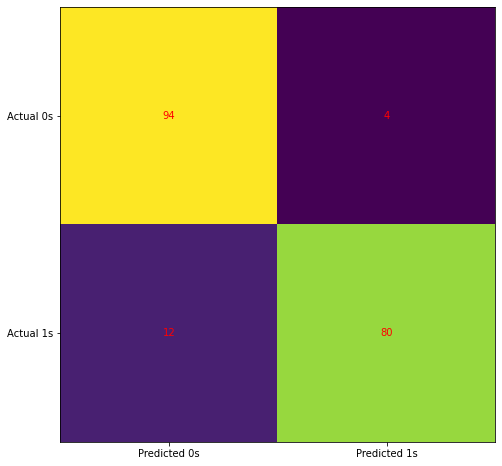


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        98
           1       0.95      0.87      0.91        92

    accuracy                           0.92       190
   macro avg       0.92      0.91      0.92       190
weighted avg       0.92      0.92      0.92       190



In [52]:
train_and_analyze(LogisticRegression(), X_train, Y_train)

## SVM

In [57]:
train_and_analyze(SVC(kernel="rbf"), X_train, Y_train)

> Model: <class 'sklearn.svm._classes.SVC'>

---- Optimal Theta Values ----


AttributeError: coef_ is only available when using a linear kernel

In [22]:
"""

Eu acho que esta parte ja nao é preciso, porque ja calculamos o modelo em cima com o LogisticRegression(), ja temos
os thetas... depois vou confirmar com o serras.


X = df.drop("Class", axis=1)
y = df["Class"]
m, n = X.shape[0], X.shape[1]
X = X.to_numpy()
y = y.values

alpha = 0.01
i = 1500

#Run featureNormalization to normalize X, store the means and stds.

X, X_mean, X_std = featureNormalization(X)

#After normalizing the features, add an extra column of 1's corresponding to x0 = 1.
X = np.append(np.ones((m, 1)), X, axis=1)

# Inicialize vector theta = 0
initial_theta = np.zeros((n + 1, 1))

#Run costFunction

theta, _ = gradDescent(X, y, initial_theta, alpha, i)
print("Optimal theta values:")
print(theta)
#print("Cost of initial theta is",round(cost,3) )   # ANSWER: Cost of initial theta is 0.693
#print("Gradient at initial theta (zeros):",grad)  #ANSWER: Gradient at initial theta (zeros): [[-0.1 ] [-0.28122914] [-0.25098615]]
"""

'\n\nEu acho que esta parte ja nao é preciso, porque ja calculamos o modelo em cima com o LogisticRegression(), ja temos\nos thetas... depois vou confirmar com o serras.\n\n\nX = df.drop("Class", axis=1)\ny = df["Class"]\nm, n = X.shape[0], X.shape[1]\nX = X.to_numpy()\ny = y.values\n\nalpha = 0.01\ni = 1500\n\n#Run featureNormalization to normalize X, store the means and stds.\n\nX, X_mean, X_std = featureNormalization(X)\n\n#After normalizing the features, add an extra column of 1\'s corresponding to x0 = 1.\nX = np.append(np.ones((m, 1)), X, axis=1)\n\n# Inicialize vector theta = 0\ninitial_theta = np.zeros((n + 1, 1))\n\n#Run costFunction\n\ntheta, _ = gradDescent(X, y, initial_theta, alpha, i)\nprint("Optimal theta values:")\nprint(theta)\n#print("Cost of initial theta is",round(cost,3) )   # ANSWER: Cost of initial theta is 0.693\n#print("Gradient at initial theta (zeros):",grad)  #ANSWER: Gradient at initial theta (zeros): [[-0.1 ] [-0.28122914] [-0.25098615]]\n'

## Plot the Cost Function

In [23]:
lr=[0.01, 0.1, 0.5, 1]
for i in lr:
    theta, J_history = gradDescent(X, y, initial_theta, i, 400)
    plt.plot(J_history)

plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")
plt.legend(lr, loc=0)

NameError: name 'gradDescent' is not defined

### Plotting the decision boundary

In [ ]:
pos=(y==1)
neg=(y==0)
plt.scatter(X[pos,1],X[pos,2],c="r",marker="+")
plt.scatter(X[neg,1],X[neg,2],c="b",marker="o")

x_value= np.array([np.min(X[:,1]),np.max(X[:,1])])
print(m)
print(x_value.reshape(m,1))
y_value=-(theta[0] +theta[1]*x_value)/theta[2]
plt.plot(x_value,y_value, "g")